# DDPM on CIFAR with wandb logging

In [1]:
from diffusers import UNet2DModel

import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [3]:
xl,yl = 'img','label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [4]:
dt = dls.train
xb,yb = next(iter(dt))

In [5]:
xb[0].shape

torch.Size([3, 32, 32])

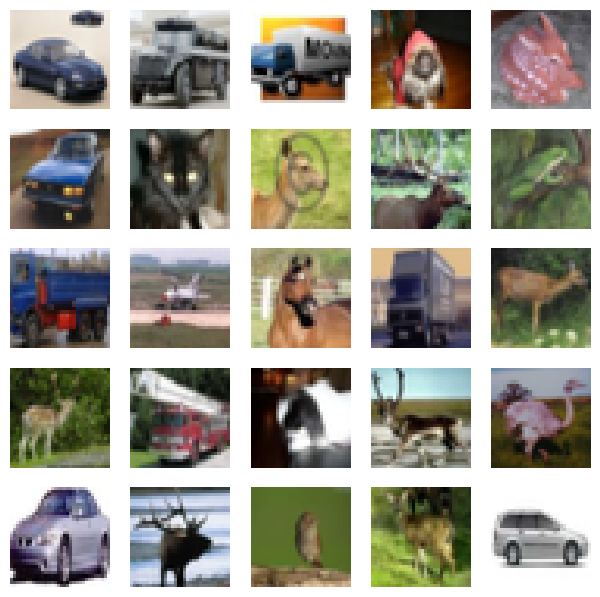

In [6]:
show_images(xb[:25]+0.5, imsize=1.5)

In [7]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [8]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [9]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [10]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([260, 790, 217, 720, 380, 256, 212, 131, 529, 457, 173, 381, 540, 261,
        304, 738, 228, 653, 933, 723, 569, 900, 498, 679, 373])

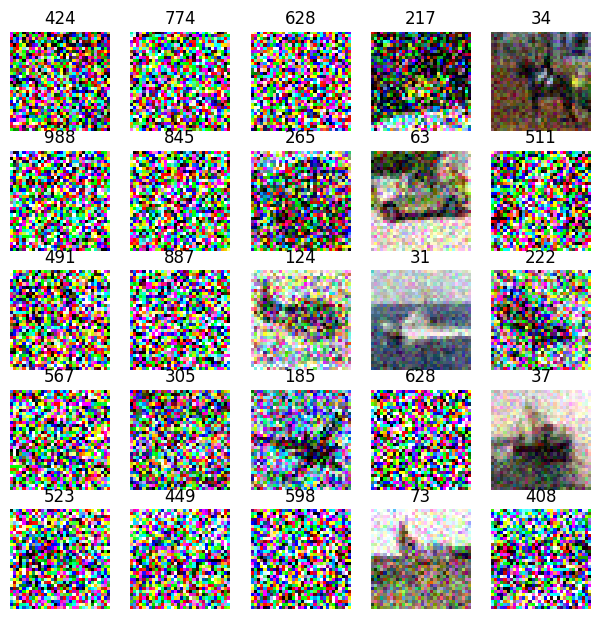

In [11]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)

# Training

In [11]:
bs = 192

In [12]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()
        for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)
    
    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [13]:
nw = fc.defaults.cpus

In [14]:
dls = DataLoaders(dl_ddpm(tds['train'], nw=nw), dl_ddpm(tds['test'], nw=nw))

In [15]:
# the model we've been using for FashionMNIST
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
sum(p.numel() for p in model.parameters())

15891907

In [16]:
# the default is a much larger model:
model = UNet(in_channels=3, out_channels=3)
sum(p.numel() for p in model.parameters())

274056163

In [17]:
clean_mem() # clean up GPU memory

In [29]:
lr = 1e-4
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.224,0,train
0.033,0,eval


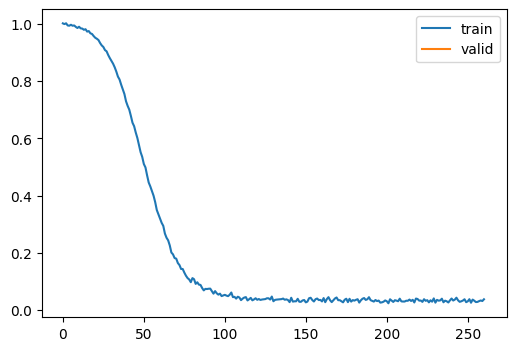

In [30]:
learn.fit(epochs)

In [18]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [32]:
%%time
samples = sample(model, (16, 3, 32, 32))

CPU times: user 1min 55s, sys: 158 ms, total: 1min 56s
Wall time: 1min 55s


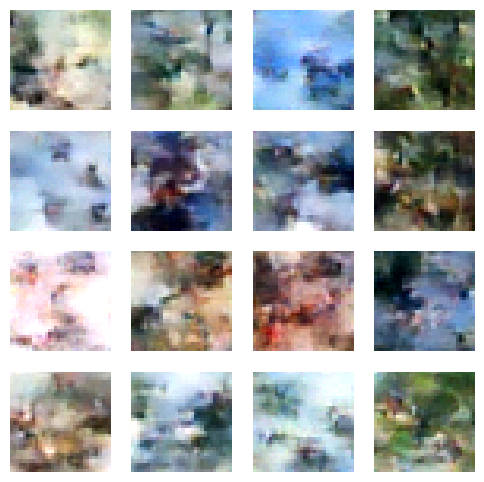

In [33]:
s = (samples[-1] + 0.5).clamp(0, 1)
show_images(s[:16], imsize=1.5)

# W&B CB

In [19]:
import wandb

class WandBCB(MetricsCB):
    order = 100
    def __init__(self, config, *ms, project='ddpm_cifar10', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        # fix check for train or val mode. NB the original version of this didn't work as `self.train` isn't set
        # it's not needed anyway as it's in the dict
        if d['train'] == 'train':
            wandb.log({'train_'+m: float(d[m]) for m in self.metrics})
        else:
            wandb.log({'val_'+m: float(d[m]) for m in self.metrics})
            wandb.log({'samples': self.sample_figure(learn)})
        print(d)

    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0, 1)
        plt.clf()
        fig, axs = get_grid(16)
        for im, ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig
    
    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss': learn.loss})
            

In [20]:
lr = 1e-4
epochs = 10
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched)]
model = model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teome. Use `wandb login --relogin` to force relogin


{'loss': '0.663', 'epoch': 0, 'train': 'train'}
{'loss': '0.176', 'epoch': 0, 'train': 'eval'}
{'loss': '0.055', 'epoch': 1, 'train': 'train'}
{'loss': '0.033', 'epoch': 1, 'train': 'eval'}
{'loss': '0.030', 'epoch': 2, 'train': 'train'}
{'loss': '0.029', 'epoch': 2, 'train': 'eval'}
{'loss': '0.028', 'epoch': 3, 'train': 'train'}
{'loss': '0.028', 'epoch': 3, 'train': 'eval'}
{'loss': '0.027', 'epoch': 4, 'train': 'train'}
{'loss': '0.026', 'epoch': 4, 'train': 'eval'}
{'loss': '0.027', 'epoch': 5, 'train': 'train'}
{'loss': '0.026', 'epoch': 5, 'train': 'eval'}
{'loss': '0.026', 'epoch': 6, 'train': 'train'}
{'loss': '0.026', 'epoch': 6, 'train': 'eval'}
{'loss': '0.026', 'epoch': 7, 'train': 'train'}
{'loss': '0.025', 'epoch': 7, 'train': 'eval'}
{'loss': '0.025', 'epoch': 8, 'train': 'train'}
{'loss': '0.025', 'epoch': 8, 'train': 'eval'}
{'loss': '0.026', 'epoch': 9, 'train': 'train'}
{'loss': '0.025', 'epoch': 9, 'train': 'eval'}


loss,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02042


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

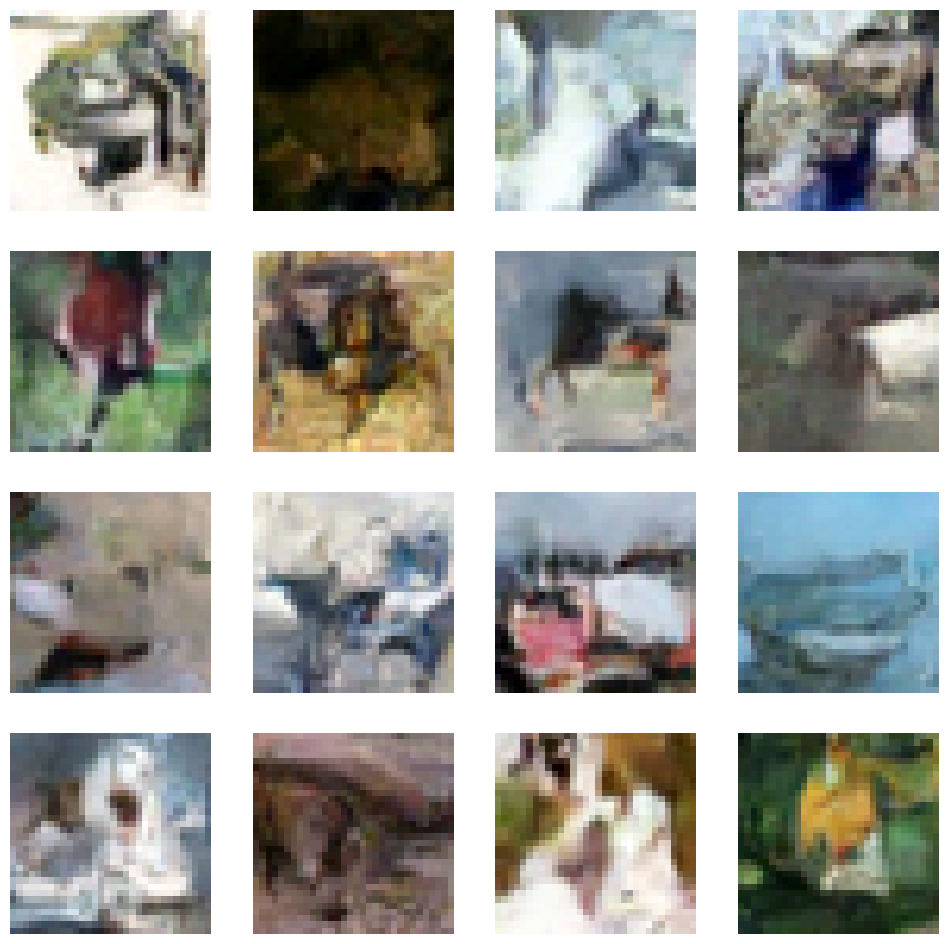

In [21]:
learn.fit(epochs)